# Biweekly Report 2
# Kyle, Carney
## Comparison of optimization algorithms

In this biweekly report I train five convolutional neural networks (CNN) using a variety of optimization algorithms. My analysis shows that the choice of optimizer greatly affects the convergence rate and overall accuracy of a model. I trained each model with one of the following optimizers: Stochastic Gradient Descent, Averaged Stochastic Gradient Descent, Adam, Adamax, and Adagrad. In order to compare these algorithms I build five CNNs from scratch and trained them to identify different species of mushrooms based on images. Through this analysis I find that Adam style optimizers greatly outperform Stochastic Gradient Descent with Adamax producing the highest accuracies.


## Background of Dataset

I am using the mushroom dataset curated by Dr. Boyuan Wang and available at [https://www.kaggle.com/mustai/mushroom-12-9528](https://www.kaggle.com/mustai/mushroom-12-9528). The dataset contains 9528 images of 12 different species of mushroom.  The accuracy of the data and labels has been confirmed by the Nordic Association of Mycologists. Previously studies have successfully used this dataset to train accurate models based on convolutional neural network architectures [https://doi.org/10.1155/2022/1173102](https://doi.org/10.1155/2022/1173102). Therefore, this dataset is accurate and of a high enough quality that it can be used to train my convolutional neural networks.


## Construction of CNN

I will proceed by building a simple convolutional neural network based on the article and code found at [https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48). This approach uses a very basic set of hyperparameters and may therefore achieve relatively small accuracies. However, this simple model should be able to highlight how the choice of optimizer affects a model.

In [115]:
#import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split


In [116]:
#project name
project_name = 'mushroom-species-classification'

In [117]:
#train and test data directory
data_dir = "Mushroom_data/train"
test_data_dir = "Mushroom_data/test"


The dataset is presplit into training, test, and validation folders. I am not confident the data is premixed, thus I manually combined the training and validation data into a single folder which I will shuffle and split. The provided test folder contains about 20% of the full datasets.

In [118]:
#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [119]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


I use torchvision to resize each image into a (150x150) tensor. This ensures that the images have a uniform size that is small enough that the GPU can train the models with the memory available. It is worth noting that most of the images in the set are larger than (150,150) so this transform generally represents a reduction in image size.

## Overview of Dataset

I will now do an exploratory data analysis of this dataset. More specifically, I will look at the balance of this dataset and observe a sample image from each class.

In [120]:
print(f"Images in training data : {len(dataset)}")
print(f"Images in test data : {len(test_dataset)}")
print(f"Percentage of images in the test data : {len(test_dataset)/(len(dataset)+len(test_dataset))}")

Images in training data : 7617
Images in test data : 1911
Percentage of images in the test data : 0.20056675062972293


### Balance of dataset

In [121]:
print("The dataset contains the following classes: \n",dataset.classes)

The dataset contains the following classes: 
 ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']



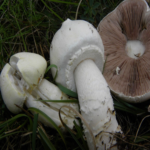
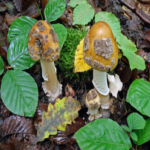
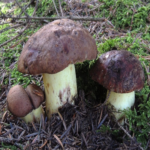
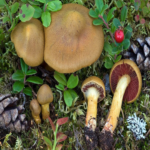
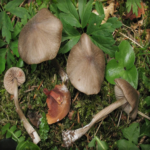
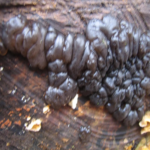
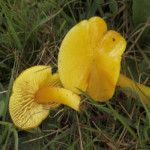
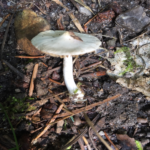
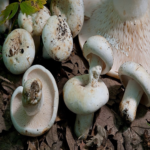
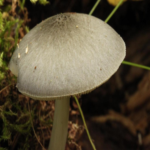
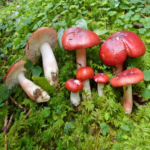
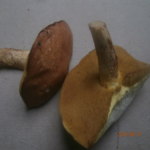


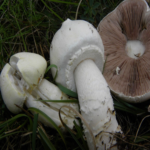
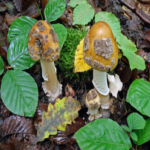
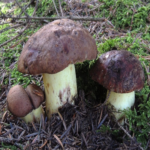
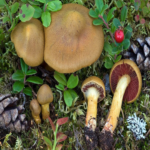
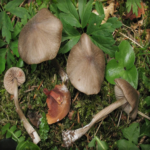
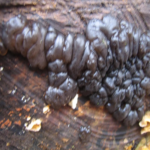
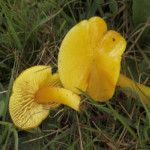
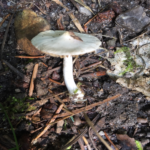
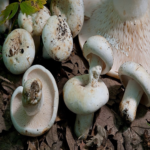
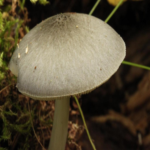
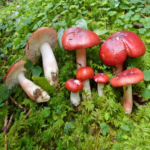
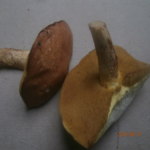

In [122]:


import ipyplot

img1, lb1 = test_dataset[1]
img2, lb2 = test_dataset[205]
img3, lb3 = test_dataset[399]
img4, lb4 = test_dataset[603]
img5, lb5 = test_dataset[793]
img6, lb6 = test_dataset[898]
img7, lb7 = test_dataset[1099]
img8, lb8 = test_dataset[1195]
img9, lb9 = test_dataset[1299]
img10, lb10 = test_dataset[1496]
img11, lb11 = test_dataset[1699]
img12, lb12 = test_dataset[1899]

sample_images = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12]
true_labels_temp = [lb1, lb2, lb3, lb4, lb5, lb6, lb7, lb8, lb9, lb10, lb11, lb12]

true_labels = []
for i in range(len(true_labels_temp)):
    true_labels.append(dataset.classes[true_labels_temp[i]])

img1 = transforms.ToPILImage()(img1)
img2 = transforms.ToPILImage()(img2)
img3 = transforms.ToPILImage()(img3)
img4 = transforms.ToPILImage()(img4)
img5 = transforms.ToPILImage()(img5)
img6 = transforms.ToPILImage()(img6)
img7 = transforms.ToPILImage()(img7)
img8 = transforms.ToPILImage()(img8)
img9 = transforms.ToPILImage()(img9)
img10 = transforms.ToPILImage()(img10)
img11 = transforms.ToPILImage()(img11)
img12 = transforms.ToPILImage()(img12)

sample_images = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12]

ipyplot.plot_images(sample_images, true_labels, max_images=12, img_width=150)

Based on the sample images, I suspect that a model will make heavy use of color to identify each species. Some species such as Hygrocube, Amanita and Russula present very distinct colors which may translate into high accuracy rates. The remaining species tend to have more similar colors and will be therefore more challenging to identify. Furthermore, most of the species have a similar shape, i.e. stock with a rounded top. However, Exidia presents a jelly like shape which the model may learn to recognize.

In [123]:
from collections import Counter

idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}  # Index to class mapping
idx_distribution = dict(Counter(dataset.targets))
class_distribution = {idx_to_class[k]:v for k, v in idx_distribution.items()}
scaled_class_distribution = {idx_to_class[k]:v/len(dataset) for k, v in idx_distribution.items()}

print(class_distribution)

{'Agaricus': 778, 'Amanita': 598, 'Boletus': 858, 'Cortinarius': 668, 'Entoloma': 671, 'Exidia': 348, 'Hygrocybe': 595, 'Inocybe': 494, 'Lactarius': 869, 'Pluteus': 352, 'Russula': 858, 'Suillus': 528}


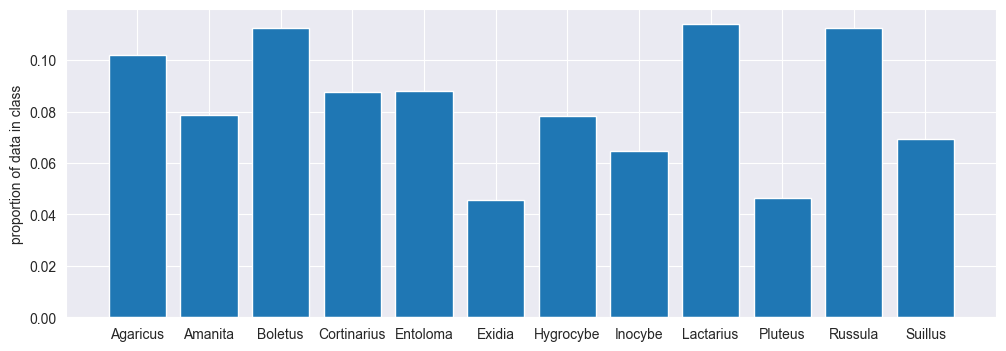

In [124]:
names = list(scaled_class_distribution.keys())
values = list(scaled_class_distribution.values())

plt.bar(range(len(scaled_class_distribution)), values, tick_label=names)
plt.rcParams["figure.figsize"] = (24,8)
plt.ylabel('proportion of data in class')
plt.show()

This dataset contains 12 species (classes) of mushrooms and is generally well balanced with most classes containing about 0.06 to 0.1 of the data. It is worth noting that Exidia and Pluteus each contain about 0.045 of the data and are therefore underrepresented. This may bias our dataset and reduce the model accuracy. For this initial attempt to train the CNN I will ignore this imbalance. However, future models may be improved by gathering more data, trimming exiting data, or use a more sophisticated sampling technique.

## Data splitting

In [125]:
val_size = int(np.floor(0.2 * len(dataset)))
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")


Length of Train Data : 6094
Length of Validation Data : 1523


I now divide the dataset into training and validation data. This is a small dataset with some classes only containing around 400 entries. If the dataset was larger I would get away with using a small percentage of validation data. However, for the current dataset I reserve the standard 20% of the training data for validation.

In [126]:
batch_size = 64

In [127]:
#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

In [128]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (32,24))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

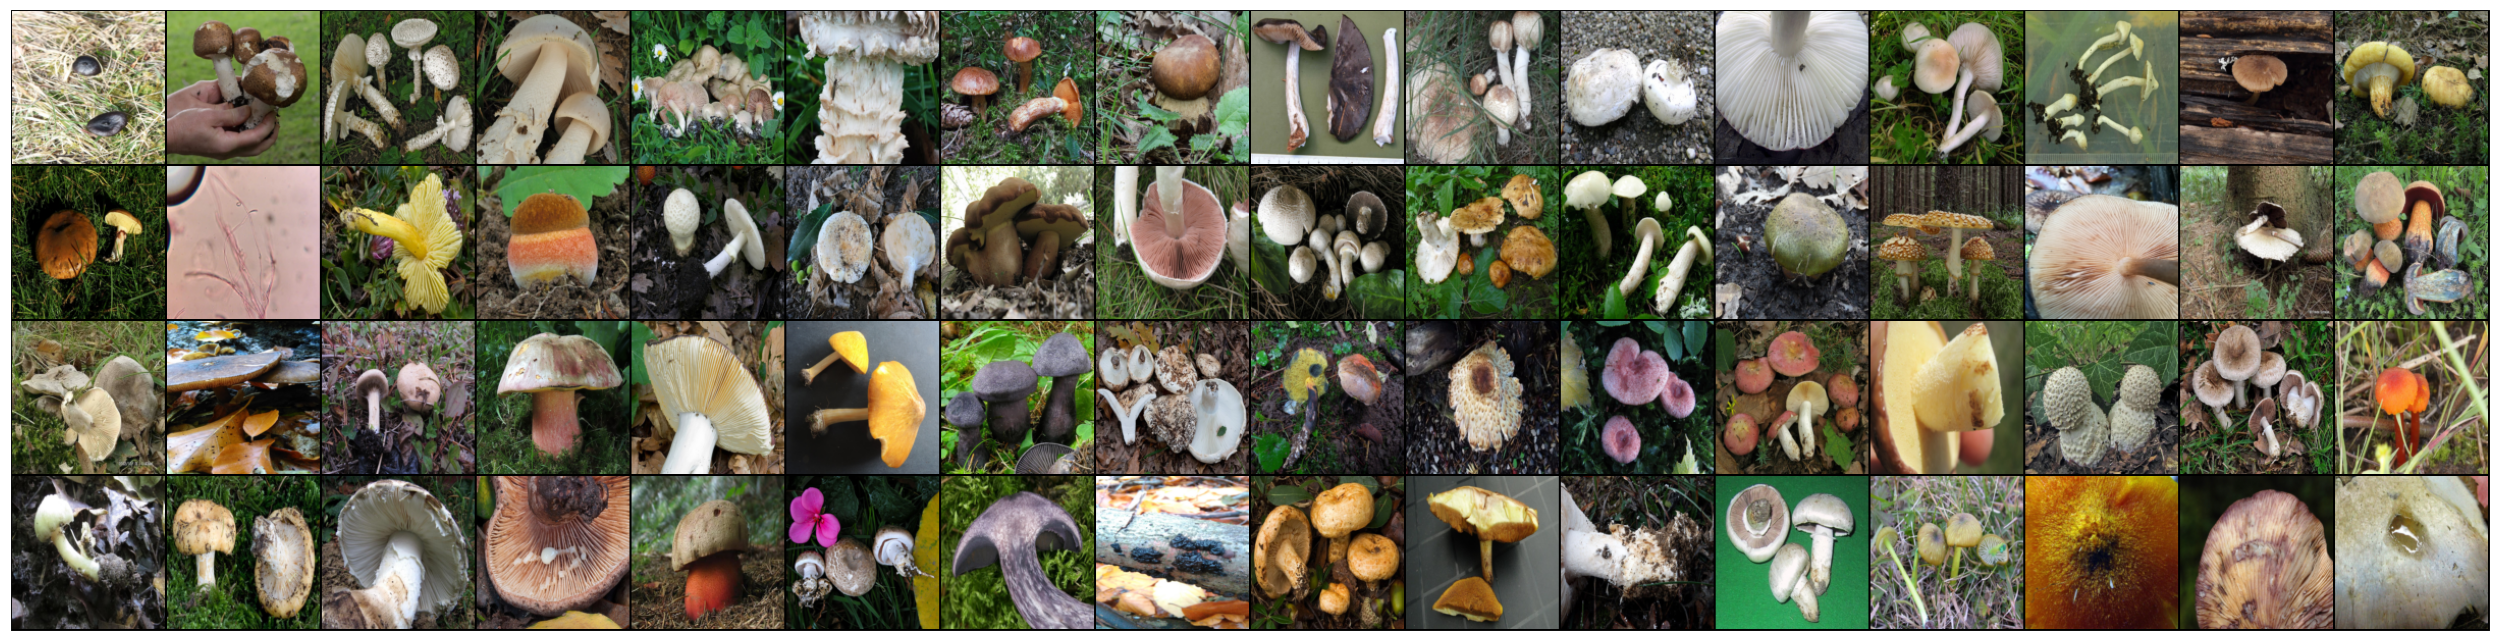

In [129]:
show_batch(train_dl)

 It is not computationally feasible to pass a model the full collection of images all at once. Thus, I break the training data into batches of 64 images. I chose a batch size 64 as it is large enough to help with the runtime on my computer while still achieving a relatively high accuracy. Note, printing the images within the batch show that most images are of a high quality.

## Model construction
I now construct the model by building a generic CNN base model which I will expand to include multiple CNN layers.

### Base model
This base model includes the generic processes used by every CNN model.

In [130]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Specialized model
This model includes the hyperparameters used by this specific model. Note, I am using a very simple model with 3 CNN blocks composed of 2 convolution layers and 1 pool layer. The CNN layers are followed by a flattening layer that reduces the size of the features.

In [131]:
class MushroomSpeciesClassification(ImageClassificationBase):

    def __init__(self):

        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256 ,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,len(dataset.classes))
        )

    def forward(self, xb):
        return self.network(xb)

### Initiate instance of model


In [132]:
model = MushroomSpeciesClassification()
model

MushroomSpeciesClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18):

In [133]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 150, 150])
out.shape: torch.Size([64, 12])
out[0]: tensor([-0.0278, -0.0146,  0.0029, -0.0414, -0.0422,  0.0145,  0.0025,  0.0396,
        -0.0213, -0.0053,  0.0350, -0.0413], grad_fn=<SelectBackward0>)


## Prepare device

I will now see if the GPU is available to be used via cuda. If not the model will be trained on with the CPU. After the device has been selected I load it with data.

In [134]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [135]:
device = get_default_device()
device

device(type='cuda')

In [136]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

MushroomSpeciesClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18):

## Training
I will now train the model. I begin by defining the training commands.

In [137]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

I now load 5 models into the device. I will use these models to compare the performance of the 5 optimization algorithms.

In [138]:
#load the model to the device
model1 = to_device(MushroomSpeciesClassification(),device)
model2 = to_device(MushroomSpeciesClassification(),device)
model3 = to_device(MushroomSpeciesClassification(),device)
model4 = to_device(MushroomSpeciesClassification(),device)
model5 = to_device(MushroomSpeciesClassification(),device)

In [139]:
#initial evaluation of the model
evaluate(model1,val_dl)

{'val_loss': 2.481721878051758, 'val_acc': 0.07878736406564713}

### Stochastic Gradient Descent (SGD)

The method of stochastic gradient descent uses batch samples to estimate gradient descent. I implemented the basic version of this method, i.e. no momentum, dampening, or weighted decay.

In [140]:
#set the no. of epochs, optimizer function and learning rate
num_epochs = 5
opt_func = torch.optim.SGD
lr = 0.001

In [141]:
#fitting the model on training data and record the result after each epoch
history1 = fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.4820, val_loss: 2.4808, val_acc: 0.0788
Epoch [1], train_loss: 2.4810, val_loss: 2.4799, val_acc: 0.1114
Epoch [2], train_loss: 2.4800, val_loss: 2.4791, val_acc: 0.1122
Epoch [3], train_loss: 2.4792, val_loss: 2.4783, val_acc: 0.1122
Epoch [4], train_loss: 2.4783, val_loss: 2.4775, val_acc: 0.1122


### Averaged Stochastic Gradient Descent (ASGD)

The method of averaged stochastic gradient descent expands upon SGD by averaging each new gradient with the previous gradients. This method is particularly useful for reducing noise and preventing the gradient from cycling around a minimum.

In [142]:
opt_func = torch.optim.ASGD

In [143]:
#fitting the model on training data and record the result after each epoch
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.4839, val_loss: 2.4841, val_acc: 0.0444
Epoch [1], train_loss: 2.4830, val_loss: 2.4832, val_acc: 0.1122
Epoch [2], train_loss: 2.4822, val_loss: 2.4824, val_acc: 0.1122
Epoch [3], train_loss: 2.4813, val_loss: 2.4816, val_acc: 0.1122
Epoch [4], train_loss: 2.4805, val_loss: 2.4809, val_acc: 0.1122


### Adam

Adam is a combination of many established optimizers that uses exponentially weighted moving averages to estimate a momentum and the second moment of the gradient. In pytorch the default parameter values are betas=(0.9, 0.999) and eps=1e-08 with no weight decay.

In [144]:
opt_func = torch.optim.Adam

In [145]:
#fitting the model on training data and record the result after each epoch
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.4373, val_loss: 2.3567, val_acc: 0.1658
Epoch [1], train_loss: 2.2881, val_loss: 2.2181, val_acc: 0.2348
Epoch [2], train_loss: 2.1764, val_loss: 2.1255, val_acc: 0.2618
Epoch [3], train_loss: 2.0745, val_loss: 2.0956, val_acc: 0.2610
Epoch [4], train_loss: 1.9406, val_loss: 2.0082, val_acc: 0.3050


### Adamax

Adam is a variant of Adam that replaces the L2 norm with the infinity norm. The Adamax optimizer tends to be very useful when working with very sparse parameter updates.

In [146]:
opt_func = torch.optim.Adamax

In [147]:
#fitting the model on training data and record the result after each epoch
history4 = fit(num_epochs, lr, model4, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3920, val_loss: 2.2998, val_acc: 0.1820
Epoch [1], train_loss: 2.2373, val_loss: 2.1877, val_acc: 0.2488
Epoch [2], train_loss: 2.0965, val_loss: 2.0614, val_acc: 0.3018
Epoch [3], train_loss: 1.9263, val_loss: 1.9859, val_acc: 0.3106
Epoch [4], train_loss: 1.6958, val_loss: 1.9936, val_acc: 0.3286


### Adagrad

The Adagrad was developed to allow the learning rate of a system to adaptively scale along each dimension. This method ensures that sparse parameters use a higher learning rate and therefore converge at a reasonable rate.

In [148]:
opt_func = torch.optim.Adagrad

In [149]:
#fitting the model on training data and record the result after each epoch
history5 = fit(num_epochs, lr, model5, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.4147, val_loss: 2.4714, val_acc: 0.1214
Epoch [1], train_loss: 2.2384, val_loss: 2.2354, val_acc: 0.2419
Epoch [2], train_loss: 2.1188, val_loss: 2.1205, val_acc: 0.2715
Epoch [3], train_loss: 1.9956, val_loss: 2.1392, val_acc: 0.2689
Epoch [4], train_loss: 1.8614, val_loss: 2.1170, val_acc: 0.2765


## Results

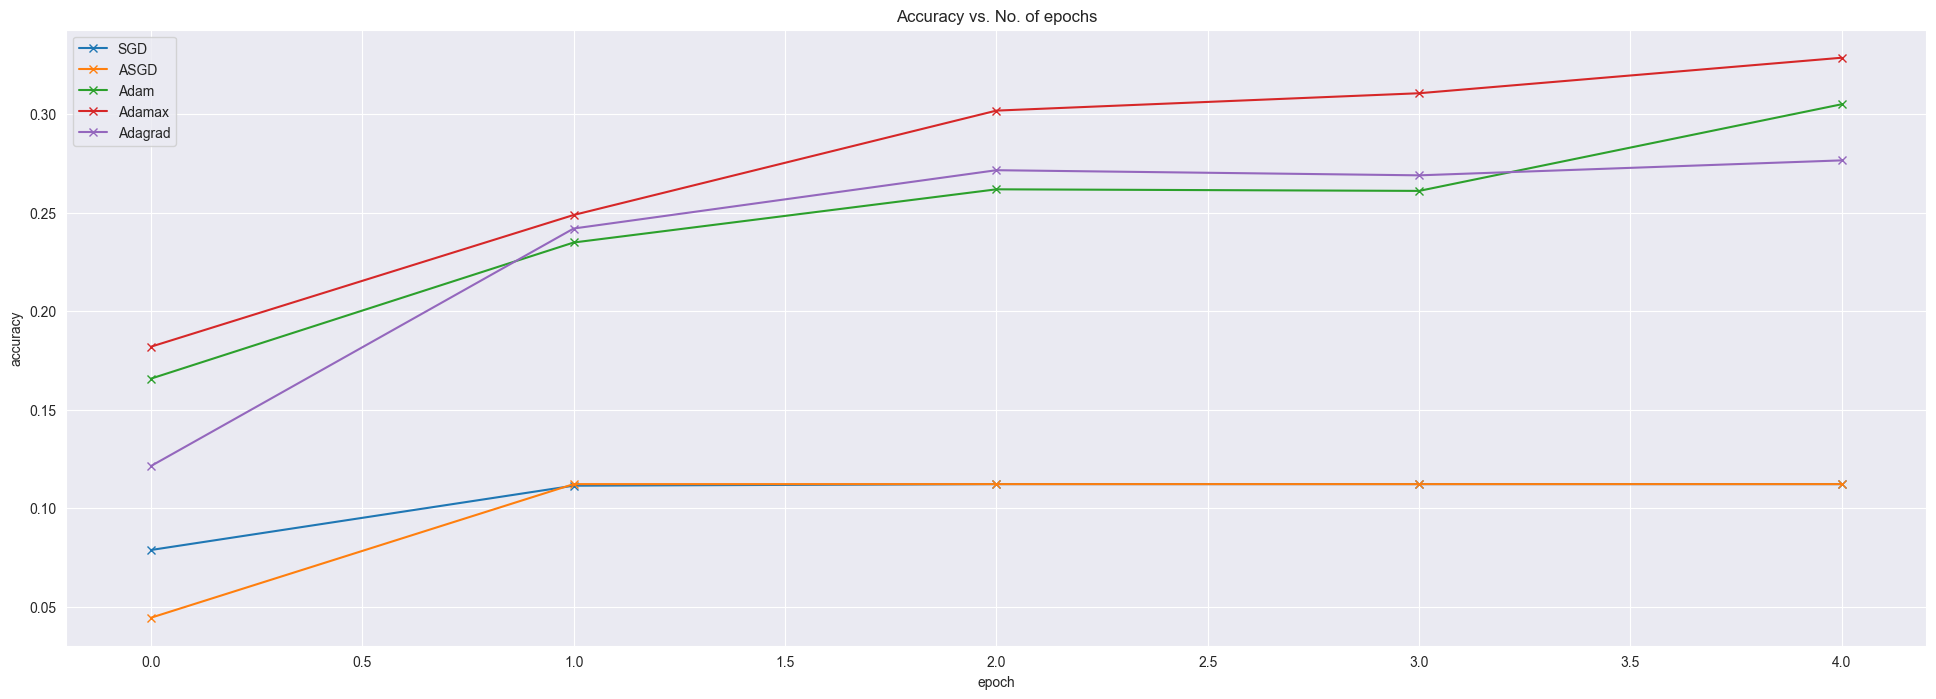

In [150]:
def plot_accuracies(history1,history2,history3,history4,history5):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history1]
    plt.plot(accuracies, '-x', label = 'SGD')
    accuracies = [x['val_acc'] for x in history2]
    plt.plot(accuracies, '-x', label = 'ASGD')
    accuracies = [x['val_acc'] for x in history3]
    plt.plot(accuracies, '-x', label = 'Adam')
    accuracies = [x['val_acc'] for x in history4]
    plt.plot(accuracies, '-x', label = 'Adamax')
    accuracies = [x['val_acc'] for x in history5]
    plt.plot(accuracies, '-x', label = 'Adagrad')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.legend()
    plt.rcParams["figure.figsize"] = (12,4)


plot_accuracies(history1,history2,history3,history4,history5)

In [151]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
print(f"Stochastic Gradient Descent:")
result = evaluate(model1, test_loader)
print(result)
print(f"Averaged Stochastic Gradient Descent:")
result = evaluate(model2, test_loader)
print(result)
print(f"Adam:")
result = evaluate(model3, test_loader)
print(result)
print(f"Adamax:")
result = evaluate(model4, test_loader)
print(result)
print(f"Adagrad:")
result = evaluate(model5, test_loader)
print(result)

Stochastic Gradient Descent:
{'val_loss': 2.4779350757598877, 'val_acc': 0.11354167014360428}
Averaged Stochastic Gradient Descent:
{'val_loss': 2.4804601669311523, 'val_acc': 0.11354167014360428}
Adam:
{'val_loss': 2.0477731227874756, 'val_acc': 0.2889355719089508}
Adamax:
{'val_loss': 2.027381420135498, 'val_acc': 0.3336397111415863}
Adagrad:
{'val_loss': 2.1485824584960938, 'val_acc': 0.2716298997402191}


I found that the Adam methods and Adagrad greatly outperformed the SGD and ASGD. This is likely due to Adam and Adagrad use adaptive timesteps while SGD uses a fixed timestep. As a result, SGD and ASGD converge at a much slower rate than the other methods. In the end, Adamax had the highest accuracy and lowest loss with the test data. It is worth noting that these results may vay with the learning rate.

## Analysis of Adamax Model

I will now consider the performance of the model trained on Adamax. I will consider how well this model identifies each class as well as having it identify a collection of sample images.

In [152]:
test_dl = DataLoader(test_dataset, 2*batch_size, num_workers = 4, pin_memory = True)
test_dl = DeviceDataLoader(test_dl, device)

In [157]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_dl:
        output = model4(images) # Feed Model

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


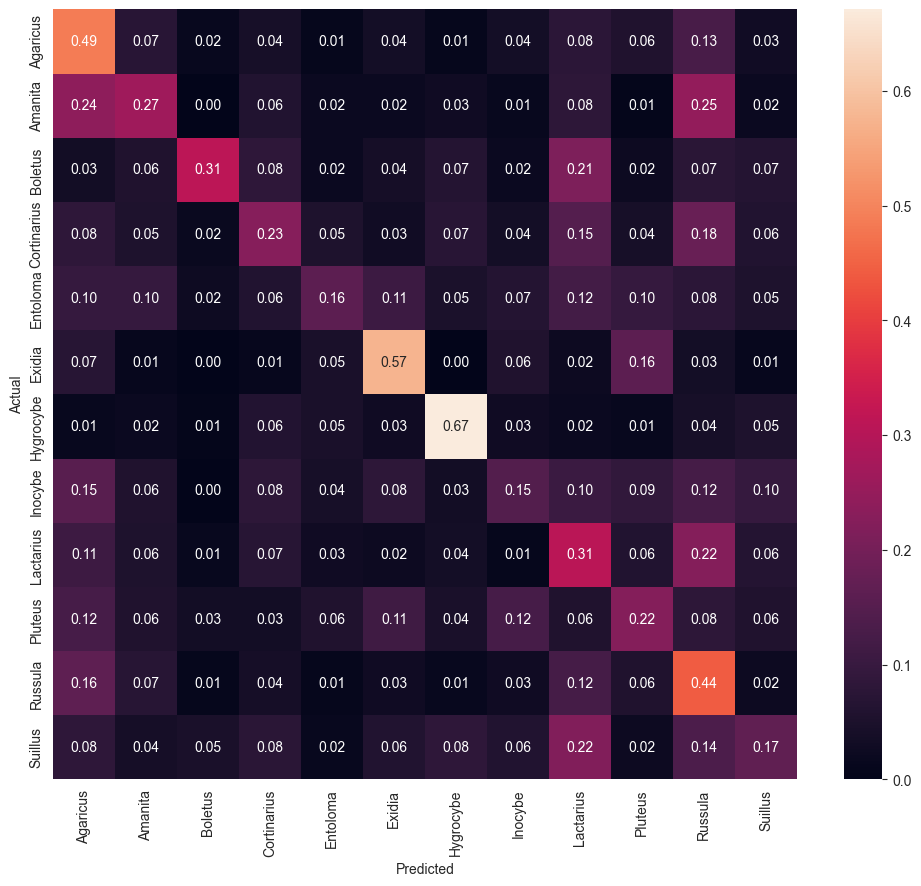

In [161]:
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12,10))

sn.heatmap(cmn, annot = True, fmt = '.2f', xticklabels= dataset.classes, yticklabels= dataset.classes )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block = False)

The heat map clearly shows that this model has room for improvement. The model was only able to identify 6 classes more than 30% of the time. As expected the model performed above average at identifying Russula, Hygrocybe, and Exidia.

In [159]:
# make invisible image prediction
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

C:\Users\kyle\AppData\Local\Programs\Python\Python310\lib\site-packages\ipyplot\_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



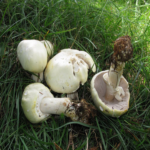
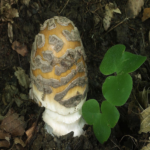
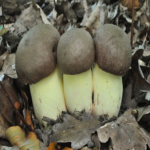
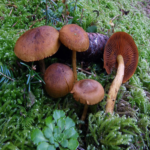
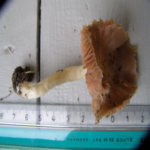
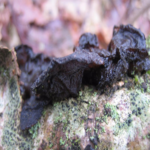
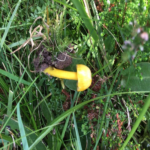
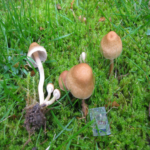
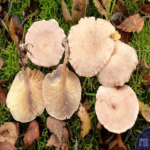
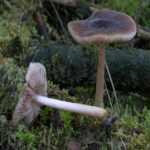
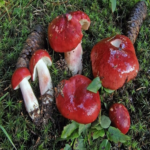
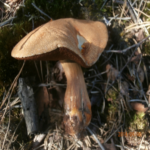


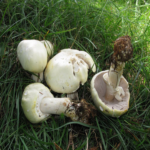
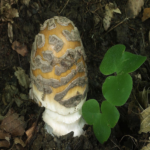
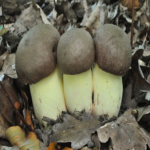
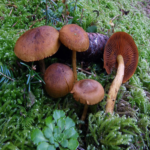
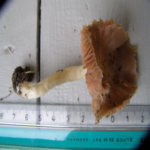
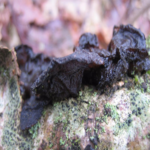
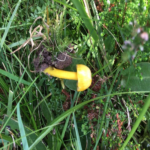
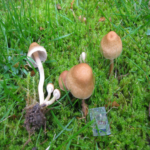
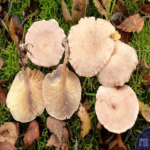
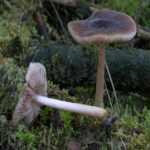
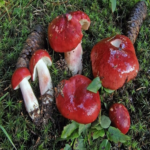
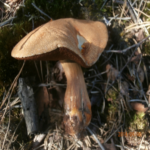

In [160]:
img1, lb1 = test_dataset[0]
img2, lb2 = test_dataset[206]
img3, lb3 = test_dataset[400]
img4, lb4 = test_dataset[601]
img5, lb5 = test_dataset[797]
img6, lb6 = test_dataset[899]
img7, lb7 = test_dataset[1100]
img8, lb8 = test_dataset[1196]
img9, lb9 = test_dataset[1300]
img10, lb10 = test_dataset[1502]
img11, lb11 = test_dataset[1700]
img12, lb12 = test_dataset[1900]

sample_images = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12]
true_labels_temp = [lb1, lb2, lb3, lb4, lb5, lb6, lb7, lb8, lb9, lb10, lb11, lb12]

true_labels = []
for i in range(len(true_labels_temp)):
    true_labels.append(dataset.classes[true_labels_temp[i]])

predict_labels = []
for i in sample_images:
    output = predict_img_class(i,model4)
    predict_labels.append(output)

img1 = transforms.ToPILImage()(img1)
img2 = transforms.ToPILImage()(img2)
img3 = transforms.ToPILImage()(img3)
img4 = transforms.ToPILImage()(img4)
img5 = transforms.ToPILImage()(img5)
img6 = transforms.ToPILImage()(img6)
img7 = transforms.ToPILImage()(img7)
img8 = transforms.ToPILImage()(img8)
img9 = transforms.ToPILImage()(img9)
img10 = transforms.ToPILImage()(img10)
img11 = transforms.ToPILImage()(img11)
img12 = transforms.ToPILImage()(img12)

sample_images = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12]

combined_lables = ["Predicted: " + i + "\n" + " Correct: " + j for i, j in zip(predict_labels, true_labels)]

ipyplot.plot_images(sample_images, combined_lables, max_images=12, img_width=150)

## Conclusion

This study highlights the value of trying multiple optimizers on a dataset as each optimizer performs differently from dataset to dataset. More specifically, I found that Adamax outperformed Adam on this dataset. This study was limited by the simple model's tendency to overfit under few epochs thus some of our results may be due to statistical noise. However, these results suggest that my future mushroom identifier models should use Adamax. For my next report I will investigate methods for preventing overfitting such as data augmentation and more advanced model architectures.